In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [71]:
pd.set_option('display.min_rows', 100)

In [72]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.colormaps.get_cmap(name)(np.linspace(0.1, 0.8, n))

In [73]:
with open("metrics_16p_4b.json") as f:
    raw = json.load(f)
points = pd.json_normalize(raw)
points.rename(columns={
    "labels.status": "status", 
    "labels.provider": "provider",
    "labels.size": "size",
    "labels.epoch": "epoch"
}, inplace=True)
points["end"] = points['start'] + points['duration']

In [74]:
success = points[points["status"] == "success"].sort_values(by='start')
confirmed = points[points["status"] == "confirmed"].sort_values(by='start')

In [75]:
success.shape

(263, 9)

In [76]:
success["duration"].median()

5767.44202709198

In [77]:
confirmed["duration"].median()

96354.32606887817

In [78]:
epoches = success[["start", "end", "epoch"]].copy()
epoches = epoches.groupby("epoch").agg(start=('start', 'min'), end=('start', 'max')).reset_index()
epoches["end"] = epoches["end"] + success["duration"].median()
epoches["duration"] = epoches["end"] - epoches["start"]

In [79]:
epoches

,epoch,start,end,duration
0,17,1.683982e+05,5.024314e+05,334033.187432
1,18,6.191658e+05,7.846634e+05,165497.543161
2,19,9.262476e+05,1.098340e+06,172092.914982
3,20,1.217959e+06,1.399208e+06,181248.206474
4,21,1.519736e+06,1.692354e+06,172618.521168
5,22,1.816582e+06,1.993372e+06,176790.302523
6,23,2.108574e+06,2.313131e+06,204556.533372
7,24,2.431513e+06,2.542886e+06,111372.953011


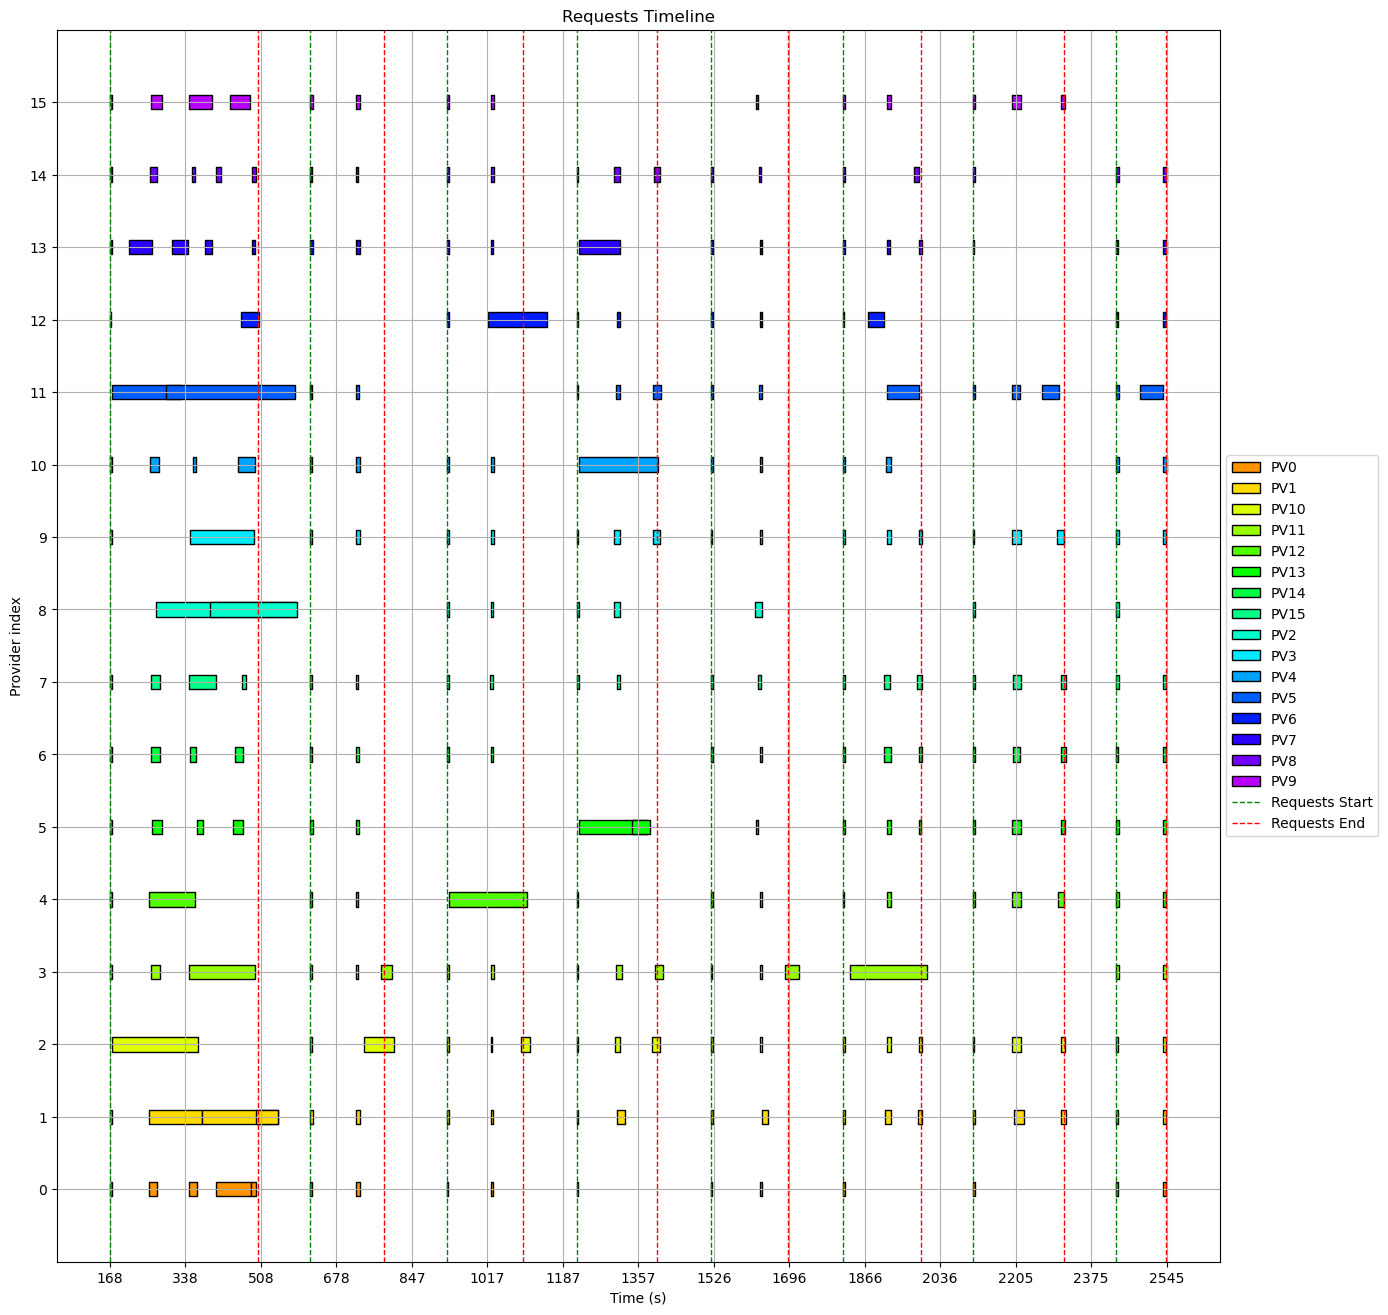

In [80]:
FACTOR = 1e3
count = len(success['provider'].unique())
plt.figure(figsize=(15, count))
cmap = get_cmap(count)

for i, (pv, group) in enumerate(success.groupby('provider')):
    data = list(zip(group['start'] / FACTOR, group['duration']  / FACTOR))
    plt.broken_barh(data, (i-0.1, 0.2), edgecolor='black', facecolor=cmap[i], label=pv)

for i, row in epoches.iterrows():
    plt.axvline(x=row['start'] / FACTOR, color='g', linestyle='--', linewidth=1, label='Requests Start' if i == 0 else "")
    plt.axvline(x=row['end'] / FACTOR, color='r', linestyle='--', linewidth=1, label='Requests End' if i == 0 else "")

# Formatting
plt.xticks(np.linspace(success["start"].min() / FACTOR, success["end"].max() / FACTOR, 15))
plt.yticks(np.linspace(0, count - 1, count))

plt.xlabel('Time (s)')
plt.ylabel('Provider index')
plt.title('Requests Timeline')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-1, count)
plt.grid(True)
plt.show()

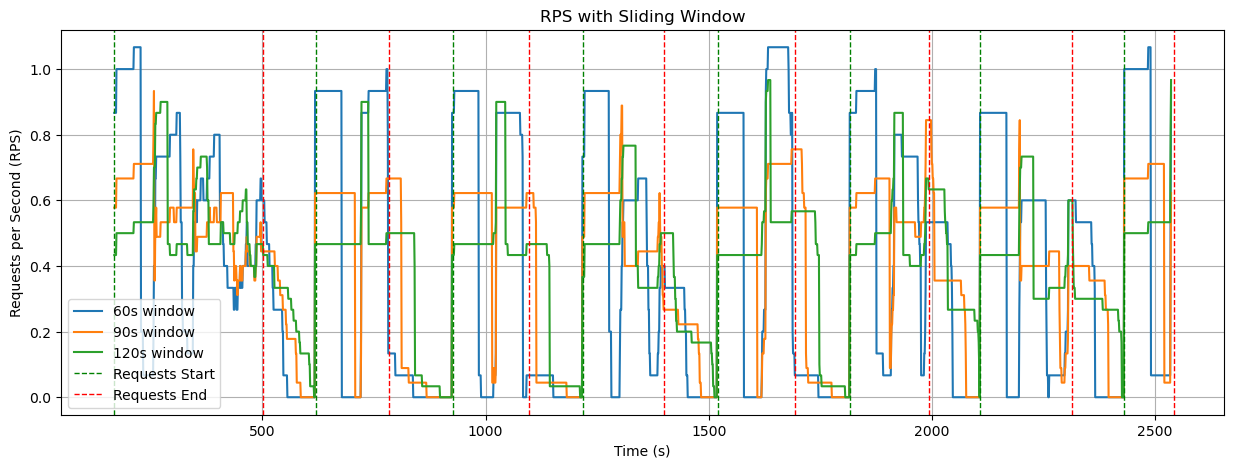

In [81]:
reqs = success[["start", "size"]].copy()
reqs["start"] = pd.to_timedelta(reqs["start"], unit="ms")
reqs = reqs.groupby("start")["size"].sum()

# Resample to 1-second frequency
resampled = reqs.resample('1S').sum()

FACTOR = 1e9
def plot_window(window_size):
    rps = resampled.rolling(window=window_size, min_periods=0).sum() / window_size
    plt.plot(rps.index / FACTOR, rps.values, label="{}s window".format(window_size))

plt.figure(figsize=(15, 5))
# Plot
plot_window(60)
plot_window(90)
plot_window(120)

for i, row in epoches.iterrows():
    start = pd.to_timedelta(row['start'], unit="ms") / pd.Timedelta(1, 'ns')
    plt.axvline(x=start / FACTOR, color='g', linestyle='--', linewidth=1, label='Requests Start' if i == 0 else "")
    end = pd.to_timedelta(row['end'], unit="ms") / pd.Timedelta(1, 'ns')
    plt.axvline(x=end / FACTOR, color='r', linestyle='--', linewidth=1, label='Requests End' if i == 0 else "")

plt.xlabel('Time (s)')
plt.ylabel('Requests per Second (RPS)')
plt.title('RPS with Sliding Window')
plt.grid(True)
plt.legend()
plt.show()

In [82]:
erps = []
for (i, epoch) in epoches.iterrows():
    count = success[success["epoch"] == epoch["epoch"]]["size"].sum()
    rps = count / epoch["duration"] * 1000
    erps.append(rps)
    print(rps)
pd.Series(erps).median()

0.6346674760965936
0.7009167494833721
0.6508112202740144
0.6400063330645871
0.6951745339262592
0.7692729638391902
0.6061893890937147
1.0415455176851205


0.6729928771001368

Text(0, 0.5, 'RPS')

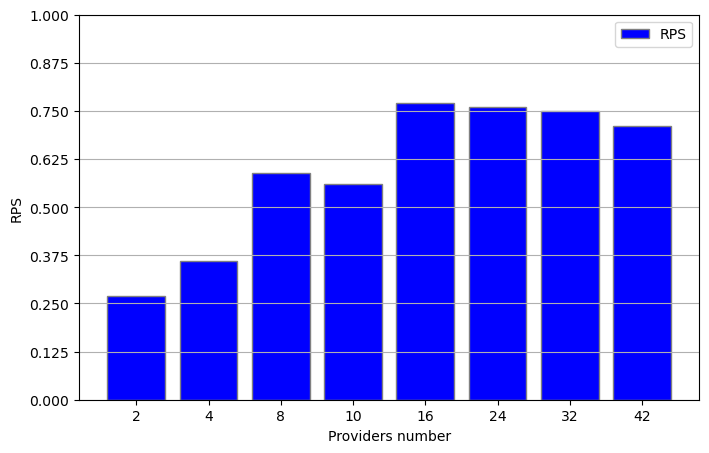

In [24]:
providers = ["2", "4", "8", "10", "16", "24", "32", "42"]
providers_rps = [0.27, 0.36, 0.59, 0.56, 0.77, 0.76, 0.75, 0.71]
barWidth = 0.8

plt.figure(figsize=(len(providers), 5))

n_providers = len(providers)
rps_x = np.arange(n_providers)

plt.bar(rps_x, providers_rps, color='blue', width=barWidth, edgecolor='grey', label='RPS')

plt.legend()
plt.grid(True, axis="y")
plt.xticks(range(n_providers), providers)
plt.yticks(np.linspace(0, 1, 9))
plt.xlabel("Providers number")
plt.ylabel("RPS")

Text(0, 0.5, 'RPS')

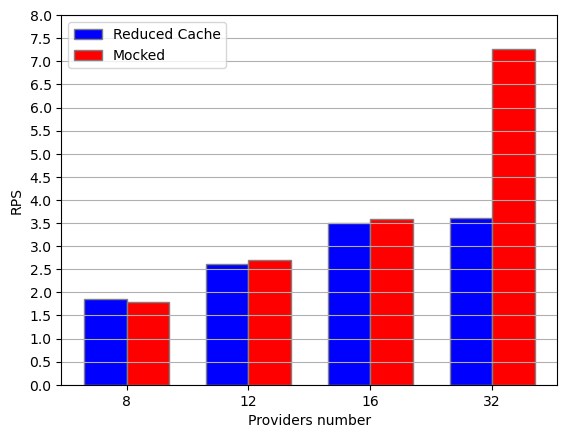

In [102]:
providers = ["8", "12", "16", "32"]
providers_rps = [1.85, 2.62, 3.5, 3.61]
providers_m_rps = [1.79, 2.70, 3.58, 7.26]

n_providers = len(providers)
barWidth = 0.35
rps_x = np.arange(n_providers)
rps_m_x = [x + barWidth for x in rps_x]

plt.bar(rps_x, providers_rps, color='blue', width=barWidth, edgecolor='grey', label='Reduced Cache')
plt.bar(rps_m_x, providers_m_rps, color='red', width=barWidth, edgecolor='grey', label='Mocked')

plt.legend()
plt.grid(True, axis="y")
plt.xticks([r + barWidth/2 for r in range(n_providers)], providers)
plt.yticks(np.linspace(0, 8, 17))
plt.xlabel("Providers number")
plt.ylabel("RPS")

Text(0, 0.5, 'Frequency')

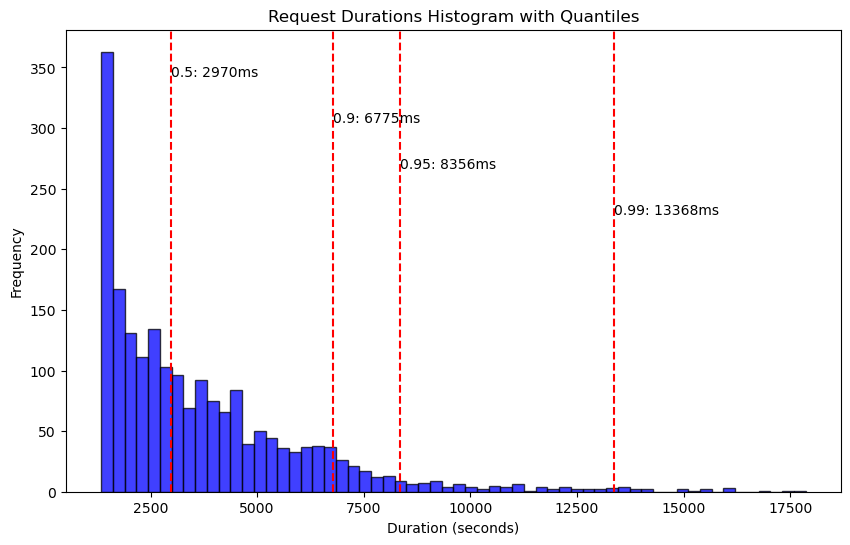

In [19]:
q = [0.5, 0.90, 0.95, 0.99]
quantiles = success['duration'].quantile(q)

# Plot histogram
plt.figure(figsize=(10, 6))
#space = np.logspace(np.log10(success['duration'].min()), np.log10(success['duration'].max()), 100)
#n, bins, patches = plt.hist(success['duration'], bins=space, alpha=0.75, color='blue', edgecolor='black')
n, bins, patches = plt.hist(success['duration'], bins=60, alpha=0.75, color='blue', edgecolor='black')

#plt.xscale('log')  # Set x-axis to log scale

# Annotate quantiles
for i, quantile in enumerate(quantiles):
    plt.axvline(x=quantile, color='r', linestyle='--')
    plt.text(quantile, plt.ylim()[1]*(9 - i)*0.1, f'{q[i]}: {quantile:.0f}ms', horizontalalignment='left', color='black')

plt.title('Request Durations Histogram with Quantiles')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')